# Import required modules and define functions

In [4]:
from simulator import Sim
from strategies import StoikovStrategy, LimitMarketStrategy, LimitMarketStrategyEnhanced, StoikovStrategyGeneralizedSingleAsset
from get_info import get_pnl
from load_data import load_md_from_file

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
PATH_TO_FILE = 'md/btcusdt:Binance:LinearPerpetual/'

In [5]:
def get_metrics(trades_list, actions_history_dict, coin_position_list):
    '''
    PnL
    ask_amount 
    bid_amount 
    n_limit_order_trades 
    n_market_order_trades
    '''
    PnL = 0
    asks = 0
    bids = 0
    market_orders = 0
    for trade in trades_list:
        if trade.side == 'ASK':
            PnL += trade.size * trade.price
            if actions_history_dict[trade.place_ts]=='limit order':
                asks += 1
            else:
                market_orders += 1
        else:
            PnL -= trade.size * trade.price
            if actions_history_dict[trade.place_ts]=='limit order':
                bids += 1
            else:
                market_orders += 1
    ## print(strategy.coin_position, strategy.current_midprice)
    PnL += strategy.coin_position * strategy.current_midprice
    sigma_coin_position = np.round(np.std(coin_position_list),4)
    return PnL, asks, bids, asks+bids, market_orders, sigma_coin_position

def market_making(trades_list, actions_history_dict): 
    MM = {}
    keys = [m for (m, n) in zip(actions_history_dict.keys(), actions_history_dict.values()) if n == 'limit order']
    for key in keys:
        MM.update({key:[0,0]})
    for trade in trades_list:
        if actions_history_dict[trade.place_ts] == 'limit order':
            if trade.side == 'ASK':
                MM[trade.place_ts][0] += 0.001
            else:
                MM[trade.place_ts][1] += 0.001
    MM = pd.DataFrame(MM).T
    MM = MM.cumsum().reset_index()
    MM.columns = ['receive_ts', 'ask_volume', 'bid_volume']
    return MM

def get_A_B_C(highest_point, X_axis_cross):
    '''
    function to get the downward parabola coefficients (a x^2 + b x + c) for LimitMarketStrategy
    highest point = [xh, yh] - highest point of parabola
    X_axis_cross = float(x0) - point of intersection with X-axis (y = 0)
    '''
    xh, yh = highest_point[0], highest_point[1]
    x0 = X_axis_cross
    a = -yh / ((x0 - xh)**2)
    b = -xh*2*a
    c = yh + (b**2)/4/a
    return np.round(a, 2) , np.round(b, 2), np.round(c, 2)
    

# Usual strategy (Benchmark)

In [7]:
from tqdm.notebook import tqdm

In [8]:
%%time
NROWS = 400_000
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta
sim = Sim(md, latency, md_latency)

delay = pd.Timedelta(0.1, 's').delta
hold_time = pd.Timedelta(10, 's').delta

possible_line_coefficients = []
for k_coef in [0.5, 1.0, 2]:
    for b_coef in [0.5, 5, 10]:
        possible_line_coefficients.append(tuple([k_coef, b_coef]))
possible_parabola_coefficients = []
for yh in [10, 100]:
    for xh in [-5, -10, -20, -50]:
        possible_parabola_coefficients.append(tuple([xh, yh, -0.5]))

results = {'coefficients':[], 'PnL':[], 'ask_amount':[], 'bid_amount':[], 'n_limit_order_trades':[], 'n_market_order_trades':[], 'coin_vol':[]}
for i in tqdm(possible_line_coefficients):
    for j in possible_parabola_coefficients:
        ## start with defining what the parabola coefficients will be
        xh, yh, x0 = j[0], j[1], j[2]
        a, b, c = get_A_B_C([xh, yh], x0)
        
        ## create a simulator object
        sim = Sim(md, latency, md_latency)
        
        ## create a strategy object
        strategy = LimitMarketStrategy(line_coefficients = (i[0], i[1]), parabola_coefficients = (a, b, c))
        ## run the strategy
        trades_list, md_list, updates_list, all_orders = strategy.run(sim)
        
        ## get PnL
        PnL, asks, bids, n_limits, n_markets, volatility_position = get_metrics(trades_list, strategy.actions_history_dict, strategy.coin_position_list)
        results['coefficients'].append(tuple([i, j]))
        results['PnL'].append(np.round(PnL, 2))
        results['ask_amount'].append(asks)
        results['bid_amount'].append(bids)
        results['n_limit_order_trades'].append(n_limits)
        results['n_market_order_trades'].append(n_markets)
        results['coin_vol'].append(volatility_position)

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
r1 = pd.DataFrame(results)
r1.to_csv('results_usual_strategy.csv')

In [12]:
r1 = pd.read_csv('results_usual_strategy.csv').drop('Unnamed: 0', axis = 1)
r1.sort_values(by = 'coin_vol', ascending = True)

,coefficients,PnL,ask_amount,bid_amount,n_limit_order_trades,n_market_order_trades,coin_vol
53,"((2, 0.5), (-10, 100, -0.5))",-322.02,97744,97636,195380,0,0.1472
48,"((2, 0.5), (-5, 10, -0.5))",-322.02,97744,97636,195380,0,0.1472
49,"((2, 0.5), (-10, 10, -0.5))",-322.02,97744,97636,195380,0,0.1472
50,"((2, 0.5), (-20, 10, -0.5))",-322.02,97744,97636,195380,0,0.1472
52,"((2, 0.5), (-5, 100, -0.5))",-322.02,97744,97636,195380,0,0.1472
...,...,...,...,...,...,...,...
59,"((2, 5), (-50, 10, -0.5))",-404.94,96270,96788,193058,184,0.2714
11,"((0.5, 5), (-50, 10, -0.5))",-404.93,96270,96788,193058,184,0.2714
19,"((0.5, 10), (-50, 10, -0.5))",-404.96,96273,96788,193061,181,0.2714
67,"((2, 10), (-50, 10, -0.5))",-404.96,96273,96788,193061,181,0.2714


## Benchmark strategy selection

In [15]:
%%time
PATH_TO_FILE = 'md/md/btcusdt_Binance_LinearPerpetual/'
best_guess = ((2, 0.5), (-10, 100, -0.5))
init_k, init_b = best_guess[0]
xh, yh, x0 = best_guess[1]
a, b, c = get_A_B_C([xh, yh], x0)

NROWS = 10_000_000
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)
print('md loaded')
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

strategy = LimitMarketStrategy(line_coefficients = (init_k, init_b), parabola_coefficients = (a, b, c))
trades_list, md_list, updates_list, all_orders = strategy.run(sim)

md loaded
CPU times: total: 8min 22s
Wall time: 8min 48s


## Analytics

In [64]:
%%time 
df = get_pnl(updates_list)
actions = pd.DataFrame(strategy.actions_history, columns =['receive_ts', 'coin_position', 'spread', 'action'])
df_to_analyze = df.merge(actions, on='receive_ts', how='left')
df_to_analyze = df_to_analyze.dropna()
df_to_analyze

CPU times: total: 12min 42s
Wall time: 13min 11s


,receive_ts,exchange_ts,total,BTC,USD,mid_price,coin_position,spread,action
0,1655942402250125991,1655942402249000000,0.00000,0.000,0.0000,19977.45,0.000,0.1,limit order
1,1655942402624789714,1655942402623000000,0.00000,0.000,0.0000,19977.45,0.000,0.1,limit order
4,1655942403346968722,1655942403346000000,0.00005,-0.001,19.9775,19977.45,-0.001,0.1,limit order
5,1655942404080791047,1655942404080000000,0.00005,-0.001,19.9775,19977.45,-0.001,0.1,limit order
6,1655942404452706766,1655942404452000000,0.00005,-0.001,19.9775,19977.45,-0.001,0.1,limit order
...,...,...,...,...,...,...,...,...,...
9143416,1656028781030799513,1656028781030000000,-380.51495,0.139,-3311.8790,21088.95,0.139,0.1,limit order
9143426,1656028781162817660,1656028781162000000,-380.50115,0.137,-3269.7010,21089.05,0.137,0.1,limit order
9143430,1656028781295503281,1656028781294000000,-380.50115,0.137,-3269.7010,21089.05,0.137,0.1,limit order
9143439,1656028781423672729,1656028781423000000,-380.50095,0.137,-3269.7008,21089.05,0.137,0.1,limit order


In [65]:
PnL, asks, bids, n_limits, n_markets, coin_vol = get_metrics(trades_list, strategy.actions_history_dict, strategy.coin_position_list)
MM = market_making(trades_list, strategy.actions_history_dict)
print(asks, bids, n_markets)

728441 728578 0


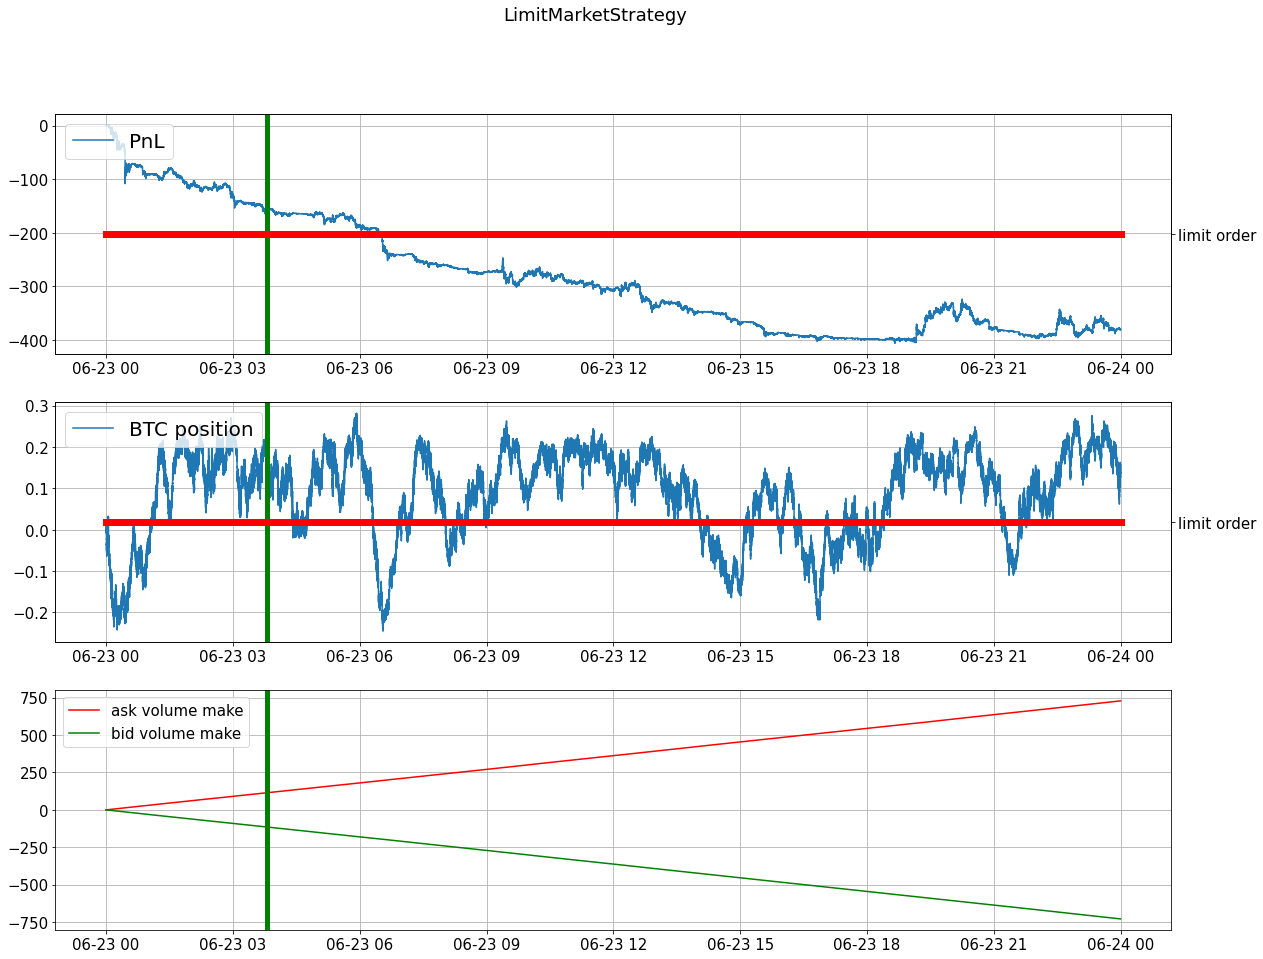

In [73]:
dt = pd.to_datetime(df_to_analyze.receive_ts)
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(20,15)
fig.suptitle('LimitMarketStrategy')
font_size = 15
plt.rcParams.update({'font.size':font_size})

ax1.plot(dt, df_to_analyze.total, '-', label = 'PnL')
ax1.grid()
ax4 = ax1.twinx()
ax4.scatter(dt, df_to_analyze.action, color = 'r', marker = ',')
ax1.legend(fontsize = 20, loc = 2)

ax2.plot(dt, df_to_analyze.coin_position, '-', label = 'BTC position')
ax5 = ax2.twinx()
ax5.scatter(dt, df_to_analyze.action, color = 'r', marker = ',')
ax2.grid()
ax2.legend(fontsize = 20, loc = 2)

ax3.plot(pd.to_datetime(MM.receive_ts), MM.ask_volume, '-', color = 'r', label = 'ask volume make')
ax3.grid()
ax3.plot(pd.to_datetime(MM.receive_ts), -1*MM.bid_volume, '-', color = 'g', label = 'bid volume make')
ax3.legend()

ax1.axvline(x = pd.to_datetime(1655956078573635138), color = 'green', linewidth = 5)
ax2.axvline(x = pd.to_datetime(1655956078573635138), color = 'green', linewidth = 5)
ax3.axvline(x = pd.to_datetime(1655956078573635138), color = 'green', linewidth = 5)
plt.show()

# Enhanced Model calibration

In [27]:
%%time
PATH_TO_FILE = 'md/md/btcusdt_Binance_LinearPerpetual/'
NROWS = 400_000
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta
sim = Sim(md, latency, md_latency)
delay = pd.Timedelta(0.1, 's').delta
hold_time = pd.Timedelta(10, 's').delta

possible_line_coefficients = []
for k_coef in [0.5, 1, 2]:
    for add_to_b_coef in [0.5, 5]:
        possible_line_coefficients.append(tuple([k_coef, add_to_b_coef]))

possible_parabola_coefficients = []
for yh in [10, 100]:
    for xh in [-5, -10, -25]:
        for x0 in [-0.5]:
            possible_parabola_coefficients.append(tuple([xh, yh, x0]))
results = {'coefficients':[], 'coin_position_slope_multiplier':[], 'PnL':[], 'ask_amount':[], 'bid_amount':[], 'n_limit_order_trades':[], 'n_market_order_trades':[], 'coin_vol':[]}
for i in possible_line_coefficients:
    for j in possible_parabola_coefficients:
        for alpha in [1, 4, 8]:
            ## start with defining what the parabola coefficients will be
            xh, yh, x0 = j[0], j[1], j[2]
            a, b, c = get_A_B_C([xh, yh], x0)        
            ## create a simulator object
            sim = Sim(md, latency, md_latency)
            ## create a strategy object
            strategy = LimitMarketStrategyEnhanced(line_coefficients = (i[0], i[1]), parabola_coefficients = (a, b, c), coin_position_multiplier = alpha)
            ## run the strategy
            trades_list, md_list, updates_list, all_orders = strategy.run(sim)
            ## get metrics
            PnL, asks, bids, n_limits, n_markets, volatility_position = get_metrics(trades_list, strategy.actions_history_dict, strategy.coin_position_list)
            results['coin_position_slope_multiplier'].append(alpha)
            results['coefficients'].append(tuple([i, j]))
            results['PnL'].append(np.round(PnL, 2))
            results['ask_amount'].append(asks)
            results['bid_amount'].append(bids)
            results['n_limit_order_trades'].append(n_limits)
            results['n_market_order_trades'].append(n_markets)
            results['coin_vol'].append(volatility_position)

CPU times: total: 2h 39min 33s
Wall time: 2h 39min 37s


In [28]:
r2 = pd.DataFrame(results)
r2.to_csv('results_better_strategy.csv')

In [14]:
r2 = pd.read_csv('results_better_strategy.csv').drop('Unnamed: 0', axis = 1)
r2.sort_values(by = 'coin_vol', ascending = True)

,coefficients,coin_position_slope_multiplier,PnL,ask_amount,bid_amount,n_limit_order_trades,n_market_order_trades,coin_vol
84,"((2, 0.5), (-10, 100, -0.5))",1,-330.71,97401,97317,194718,0,0.1670
75,"((2, 0.5), (-10, 10, -0.5))",1,-330.71,97401,97317,194718,0,0.1670
78,"((2, 0.5), (-25, 10, -0.5))",1,-330.71,97401,97317,194718,0,0.1670
81,"((2, 0.5), (-5, 100, -0.5))",1,-330.71,97401,97317,194718,0,0.1670
87,"((2, 0.5), (-25, 100, -0.5))",1,-330.71,97401,97317,194718,0,0.1670
...,...,...,...,...,...,...,...,...
43,"((1, 0.5), (-25, 10, -0.5))",4,-217.61,98506,94517,193023,3386,0.2652
80,"((2, 0.5), (-25, 10, -0.5))",8,-195.66,99228,92881,192109,5744,0.2706
44,"((1, 0.5), (-25, 10, -0.5))",8,-192.90,99274,92835,192109,5836,0.2805
7,"((0.5, 0.5), (-25, 10, -0.5))",4,-203.63,98673,94033,192706,4037,0.2848


In [27]:
## higher penalty for position - higher chance to place market orders 
## higher penalty for position - higher PnL
r2.groupby('coin_position_slope_multiplier').mean().astype(int)

,PnL,ask_amount,bid_amount,n_limit_order_trades,n_market_order_trades,coin_vol
coin_position_slope_multiplier,,,,,,
1,-357,96462,96809,193272,270,0
4,-334,96725,96474,193199,647,0
8,-293,97557,94851,192409,2955,0


In [30]:
## 1st possible strategy: (line_slope = 2, line_intercept = 0.5), (highest_point_x = -50, highest_point_y = 10, OX_intersection_x = -0.5)
## 2nd possible strategy: (line_slope = 1, line_intercept = 0.5), (highest_point_x = -50, highest_point_y = 10, OX_intersection_x = -0.5)
r2[r2['coin_position_slope_multiplier']==8].sort_values(by = 'coin_vol', ascending = False)

,coefficients,coin_position_slope_multiplier,PnL,ask_amount,bid_amount,n_limit_order_trades,n_market_order_trades,coin_vol
8,"((0.5, 0.5), (-25, 10, -0.5))",8,-192.59,99274,92833,192107,5838,0.2860
44,"((1, 0.5), (-25, 10, -0.5))",8,-192.90,99274,92835,192109,5836,0.2805
80,"((2, 0.5), (-25, 10, -0.5))",8,-195.66,99228,92881,192109,5744,0.2706
5,"((0.5, 0.5), (-10, 10, -0.5))",8,-203.78,99219,92799,192018,5894,0.2526
41,"((1, 0.5), (-10, 10, -0.5))",8,-204.07,99220,92801,192021,5893,0.2468
2,"((0.5, 0.5), (-5, 10, -0.5))",8,-207.63,99203,92788,191991,5912,0.2427
62,"((1, 5), (-25, 10, -0.5))",8,-385.49,96176,96703,192879,301,0.2394
98,"((2, 5), (-25, 10, -0.5))",8,-385.49,96173,96701,192874,302,0.2394
26,"((0.5, 5), (-25, 10, -0.5))",8,-385.49,96176,96703,192879,301,0.2394
17,"((0.5, 0.5), (-25, 100, -0.5))",8,-210.08,99191,92774,191965,5926,0.2375


# Best Enhanced strategy ##1

In [4]:
%%time
PATH_TO_FILE = 'md/md/btcusdt_Binance_LinearPerpetual/'
best_guess = ((2, 0.5), (-25, 10, -0.5))
init_k, init_b = best_guess[0]
xh, yh, x0 = best_guess[1]
a, b, c = get_A_B_C([xh, yh], x0)

NROWS = 10_000_000
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)
print('md loaded')
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

strategy = LimitMarketStrategyEnhanced(line_coefficients = (init_k, init_b), parabola_coefficients = (a, b, c), coin_position_multiplier = 4)
trades_list, md_list, updates_list, all_orders = strategy.run(sim)

md loaded
CPU times: total: 8min 36s
Wall time: 9min 4s


In [5]:
%%time 
df = get_pnl(updates_list)
actions = pd.DataFrame(strategy.actions_history, columns =['receive_ts', 'coin_position', 'spread', 'action'])
df_to_analyze = df.merge(actions, on='receive_ts', how='left')
df_to_analyze = df_to_analyze.dropna()
df_to_analyze

CPU times: total: 12min 3s
Wall time: 12min 34s


,receive_ts,exchange_ts,total,BTC,USD,mid_price,coin_position,spread,action
0,1655942402250125991,1655942402249000000,0.00000,0.000,0.0000,19977.45,0.000,0.1,limit order
1,1655942402624789714,1655942402623000000,0.00000,0.000,0.0000,19977.45,0.000,0.1,limit order
4,1655942403346968722,1655942403346000000,0.00005,-0.001,19.9775,19977.45,-0.001,0.1,limit order
5,1655942404080791047,1655942404080000000,0.00005,-0.001,19.9775,19977.45,-0.001,0.1,limit order
6,1655942404452706766,1655942404452000000,0.00005,-0.001,19.9775,19977.45,-0.001,0.1,limit order
...,...,...,...,...,...,...,...,...,...
9141175,1656028781030799513,1656028781030000000,-403.16190,0.124,-3018.1917,21088.95,0.124,0.1,limit order
9141185,1656028781162817660,1656028781162000000,-403.14955,0.121,-2954.9246,21089.05,0.121,0.1,limit order
9141189,1656028781295503281,1656028781294000000,-403.14955,0.121,-2954.9246,21089.05,0.121,0.1,limit order
9141198,1656028781423672729,1656028781423000000,-403.14935,0.121,-2954.9244,21089.05,0.121,0.1,limit order


## Analytics

In [6]:
PnL, asks, bids, n_limits, n_markets, coin_vol = get_metrics(trades_list, strategy.actions_history_dict, strategy.coin_position_list)
MM = market_making(trades_list, strategy.actions_history_dict)
print(asks, bids, n_markets)

728273 728394 0


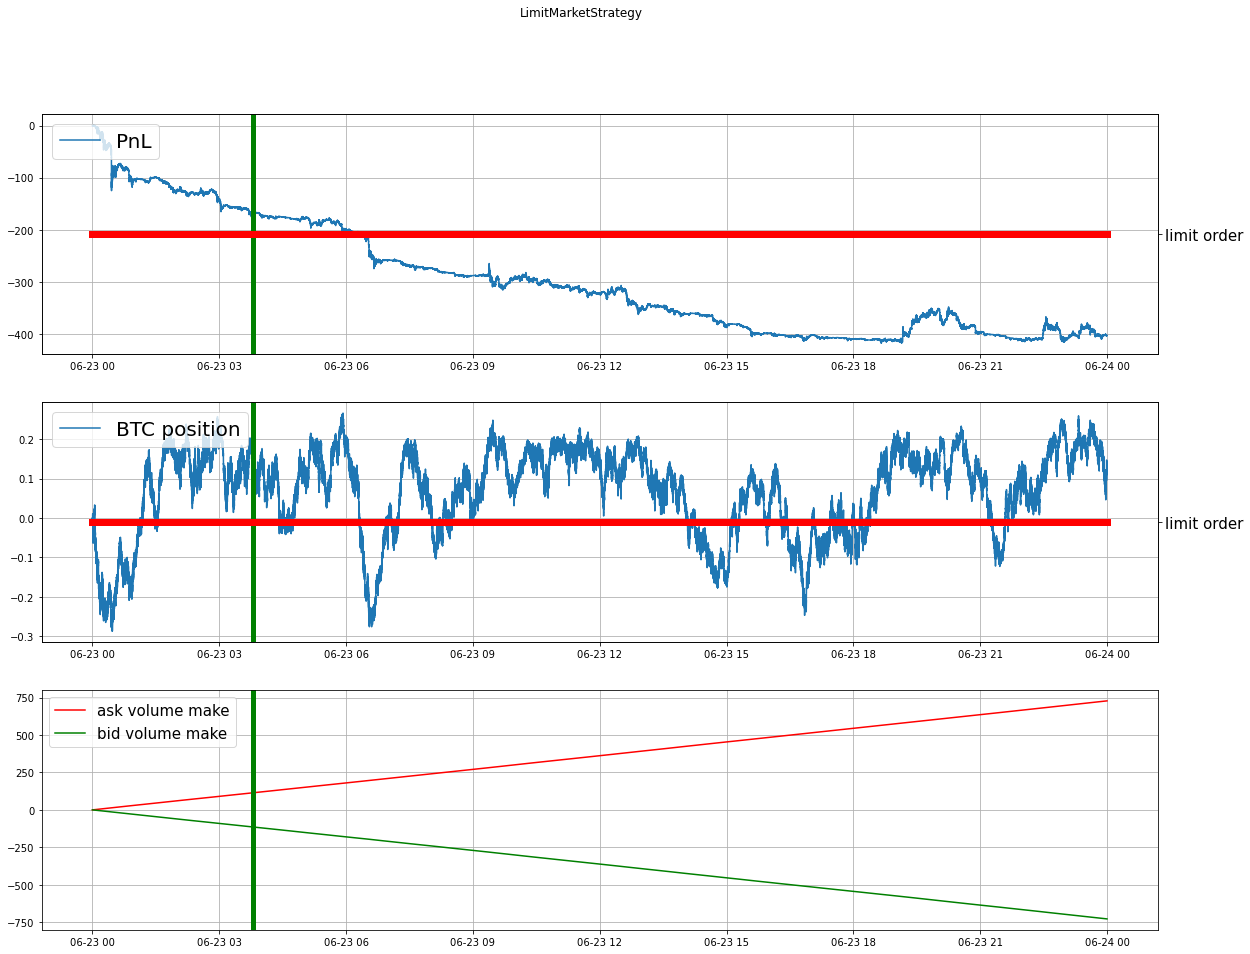

In [7]:
dt = pd.to_datetime(df_to_analyze.receive_ts)
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(20,15)
fig.suptitle('LimitMarketStrategy')
font_size = 15
plt.rcParams.update({'font.size':font_size})

ax1.plot(dt, df_to_analyze.total, '-', label = 'PnL')
ax1.grid()
ax4 = ax1.twinx()
ax4.scatter(dt, df_to_analyze.action, color = 'r', marker = ',')
ax1.legend(fontsize = 20, loc = 2)

ax2.plot(dt, df_to_analyze.coin_position, '-', label = 'BTC position')
ax5 = ax2.twinx()
ax5.scatter(dt, df_to_analyze.action, color = 'r', marker = ',')
ax2.grid()
ax2.legend(fontsize = 20, loc = 2)

ax3.plot(pd.to_datetime(MM.receive_ts), MM.ask_volume, '-', color = 'r', label = 'ask volume make')
ax3.grid()
ax3.plot(pd.to_datetime(MM.receive_ts), -1*MM.bid_volume, '-', color = 'g', label = 'bid volume make')
ax3.legend()

ax1.axvline(x = pd.to_datetime(1655956078573635138), color = 'green', linewidth = 5)
ax2.axvline(x = pd.to_datetime(1655956078573635138), color = 'green', linewidth = 5)
ax3.axvline(x = pd.to_datetime(1655956078573635138), color = 'green', linewidth = 5)
plt.show()

# Best Enhanced strategy ##2

In [8]:
%%time
best_guess = ((1, 5), (-25, 10, -0.5))	
init_k, init_b = best_guess[0]
xh, yh, x0 = best_guess[1]
a, b, c = get_A_B_C([xh, yh], x0)

NROWS = 10_000_000
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)
print('md loaded')
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

strategy = LimitMarketStrategyEnhanced(line_coefficients = (init_k, init_b), parabola_coefficients = (a, b, c), coin_position_multiplier = 8)
trades_list, md_list, updates_list, all_orders = strategy.run(sim)
df = get_pnl(updates_list)

md loaded
CPU times: total: 21min 34s
Wall time: 27min 16s


In [9]:
%%time 
df = get_pnl(updates_list)
actions = pd.DataFrame(strategy.actions_history, columns =['receive_ts', 'coin_position', 'spread', 'action'])
df_to_analyze = df.merge(actions, on='receive_ts', how='left')
df_to_analyze = df_to_analyze.dropna()
df_to_analyze.tail(2)

CPU times: total: 12min 11s
Wall time: 12min 29s


,receive_ts,exchange_ts,total,BTC,USD,mid_price,coin_position,spread,action
9114266,1656028781423672729,1656028781423000000,-115.995,0.544,-11588.4382,21089.05,0.544,0.1,limit order
9114269,1656028781526713137,1656028781526000000,-115.995,0.544,-11588.4382,21089.05,0.544,0.1,limit order


## Analytics

In [10]:
PnL, asks, bids, n_limits, n_markets, coin_vol = get_metrics(trades_list, strategy.actions_history_dict, strategy.coin_position_list)
MM = market_making(trades_list, strategy.actions_history_dict)
print(asks, bids, n_markets)

724750 726868 1574


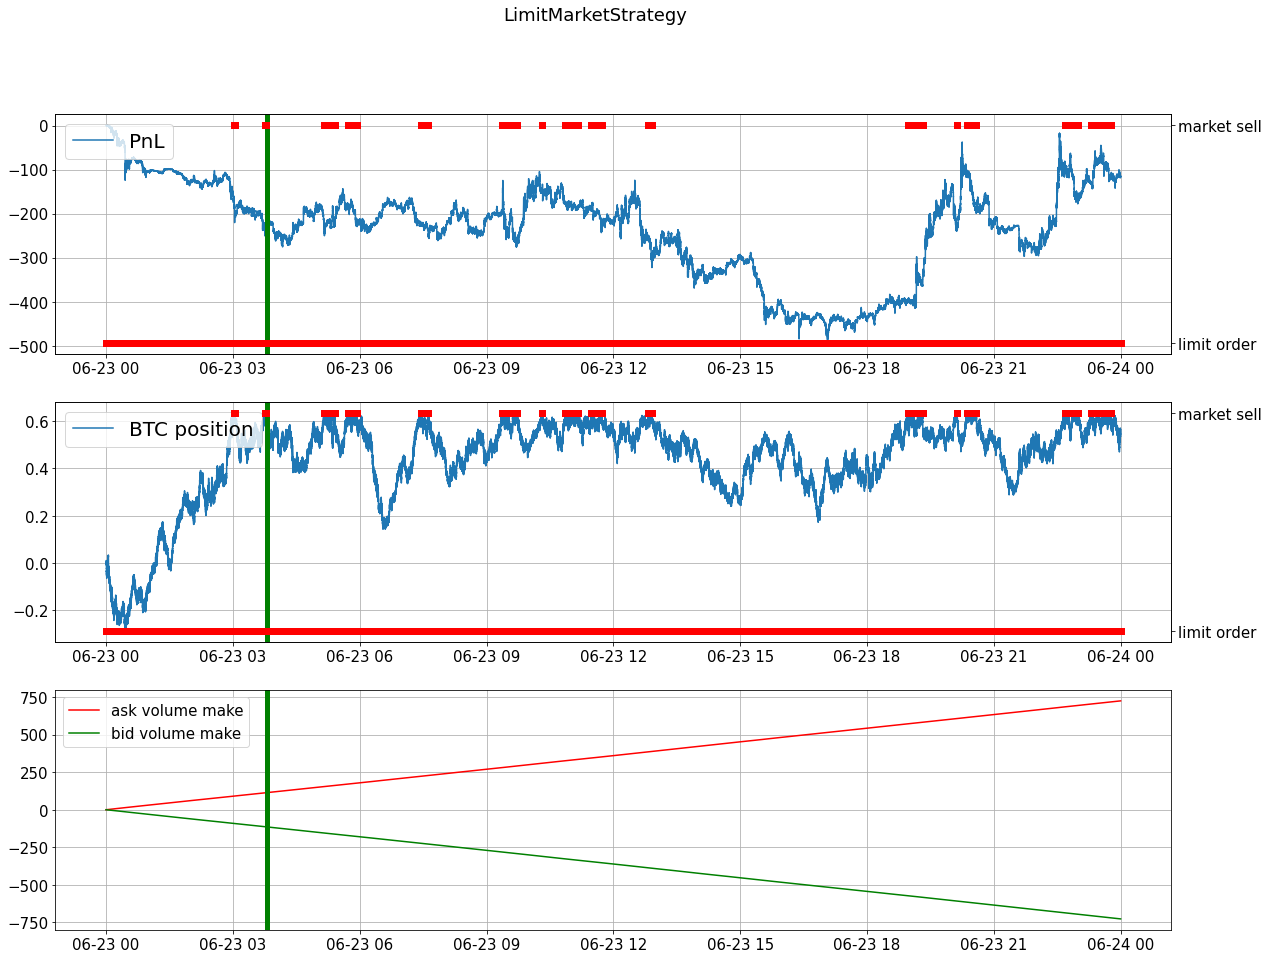

In [11]:
dt = pd.to_datetime(df_to_analyze.receive_ts)
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(20,15)
fig.suptitle('LimitMarketStrategy')
font_size = 15
plt.rcParams.update({'font.size':font_size})

ax1.plot(dt, df_to_analyze.total, '-', label = 'PnL')
ax1.grid()
ax4 = ax1.twinx()
ax4.scatter(dt, df_to_analyze.action, color = 'r', marker = ',')
ax1.legend(fontsize = 20, loc = 2)

ax2.plot(dt, df_to_analyze.coin_position, '-', label = 'BTC position')
ax5 = ax2.twinx()
ax5.scatter(dt, df_to_analyze.action, color = 'r', marker = ',')
ax2.grid()
ax2.legend(fontsize = 20, loc = 2)

ax3.plot(pd.to_datetime(MM.receive_ts), MM.ask_volume, '-', color = 'r', label = 'ask volume make')
ax3.grid()
ax3.plot(pd.to_datetime(MM.receive_ts), -1*MM.bid_volume, '-', color = 'g', label = 'bid volume make')
ax3.legend()

ax1.axvline(x = pd.to_datetime(1655956078573635138), color = 'green', linewidth = 5)
ax2.axvline(x = pd.to_datetime(1655956078573635138), color = 'green', linewidth = 5)
ax3.axvline(x = pd.to_datetime(1655956078573635138), color = 'green', linewidth = 5)
plt.show()

# Stoikov Strategy

In [5]:
%%time
NROWS = 10_000_000
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)
print('md loaded')
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

strategy = StoikovStrategy(delay = latency, hold_time = pd.Timedelta(10, 's').delta, trade_size = 0.001, risk_aversion = 1)
trades_list, md_list, updates_list, all_orders = strategy.run(sim)

md loaded
CPU times: total: 8min 56s
Wall time: 8min 58s


In [6]:
trades = pd.DataFrame(strategy.trades_dict).sort_values(by = 'receive_ts')
trades['ask_volume'] = (trades['side'].map({'ASK':1, 'BID':0}) * trades['size']).cumsum()
trades['bid_volume'] = (trades['side'].map({'ASK':0, 'BID':1}) * trades['size']).cumsum()
trades['coin_position'] = (trades['side'].map({'ASK':-1, 'BID':+1}) * trades['size']).cumsum()
trades['cash_flow'] = trades['side'].map({'ASK':+1, 'BID':-1}) * trades['size'] * trades['price']
trades['PnL'] = trades['cash_flow'].cumsum() + trades['coin_position'] * trades['mid_price']
trades.tail(3)

,place_ts,exchange_ts,receive_ts,trade_id,order_id,side,size,price,execute,mid_price,ask_volume,bid_volume,coin_position,cash_flow,PnL
98190,1656028780043020664,1656028780072000000,1656028780082000000,98190,6629425,ASK,0.001,21087.5,TRADE,21086.85,49.097,49.094,-0.003,21.0875,-103.71415
98191,1656028780074785756,1656028780087000000,1656028780097000000,98191,6629427,ASK,0.001,21087.5,BOOK,21087.65,49.098,49.094,-0.004,21.0875,-103.71670
98192,1656028780363636196,1656028780395000000,1656028780405000000,98192,6629447,ASK,0.001,21088.3,BOOK,21088.85,49.099,49.094,-0.005,21.0883,-103.72205


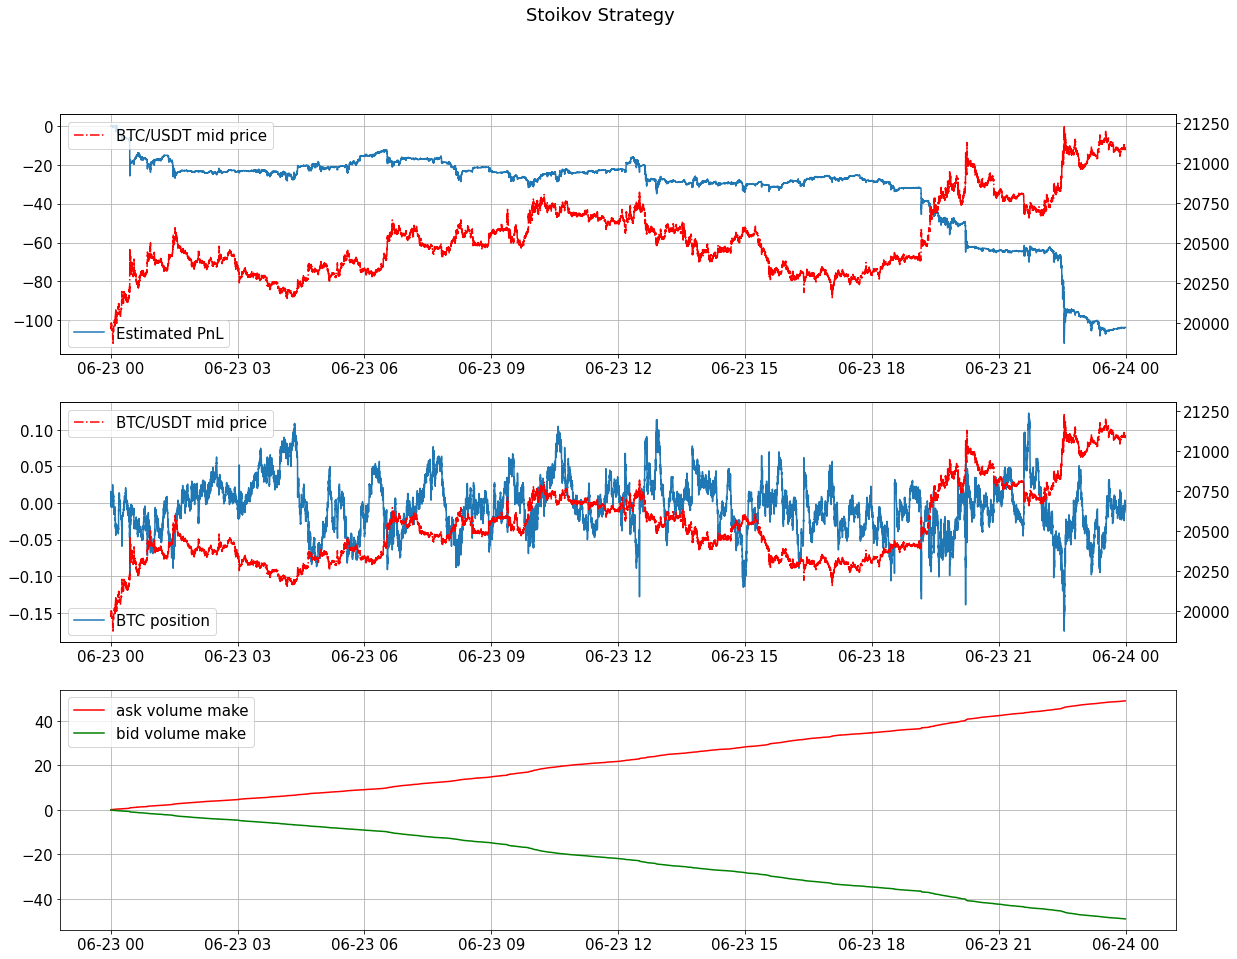

In [8]:
df_to_analyze = trades.groupby('receive_ts').last().reset_index()
dt = pd.to_datetime(df_to_analyze.receive_ts)
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(20,15)
fig.suptitle('Stoikov Strategy')
font_size = 15
plt.rcParams.update({'font.size':font_size})

ax1.plot(dt, df_to_analyze.PnL, '-', label = 'Estimated PnL')
ax1.grid()
ax4 = ax1.twinx()
ax4.plot(dt, df_to_analyze.mid_price, 'r-.', label = 'BTC/USDT mid price')
ax1.legend(fontsize = 15, loc = 3)
ax4.legend(fontsize = 15, loc = 0)

ax2.plot(dt, df_to_analyze.coin_position, '-', label = 'BTC position')
ax5 = ax2.twinx()
ax5.plot(dt, df_to_analyze.mid_price, 'r-.', label = 'BTC/USDT mid price')
ax2.grid()
ax2.legend(fontsize = 15, loc = 3)
ax5.legend(fontsize = 15, loc = 0)

ax3.plot(dt, df_to_analyze.ask_volume, '-', color = 'r', label = 'ask volume make')
ax3.grid()
ax3.plot(dt, -1*df_to_analyze.bid_volume, '-', color = 'g', label = 'bid volume make')
ax3.legend()

plt.show()

# Stoikov Strategy Generalized by Gueant 2017

In [3]:
%%time
NROWS = 10_000_000
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)
print('md loaded')
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

strategy = StoikovStrategyGeneralizedSingleAsset(trade_size = 0.001, position_limit = 0.5, delay = latency, hold_time = pd.Timedelta(10, 's').delta, risk_aversion = 1)
trades_list, md_list, updates_list, all_orders = strategy.run(sim)

KeyboardInterrupt: 

In [4]:
trades = pd.DataFrame(strategy.trades_dict).sort_values(by = 'receive_ts')
trades['ask_volume'] = (trades['side'].map({'ASK':1, 'BID':0}) * trades['size']).cumsum()
trades['bid_volume'] = (trades['side'].map({'ASK':0, 'BID':1}) * trades['size']).cumsum()
trades['coin_position'] = (trades['side'].map({'ASK':-1, 'BID':+1}) * trades['size']).cumsum()
trades['cash_flow'] = trades['side'].map({'ASK':+1, 'BID':-1}) * trades['size'] * trades['price']
trades['PnL'] = trades['cash_flow'].cumsum() + trades['coin_position'] * trades['mid_price']
trades.tail(3)

NameError: name 'strategy' is not defined

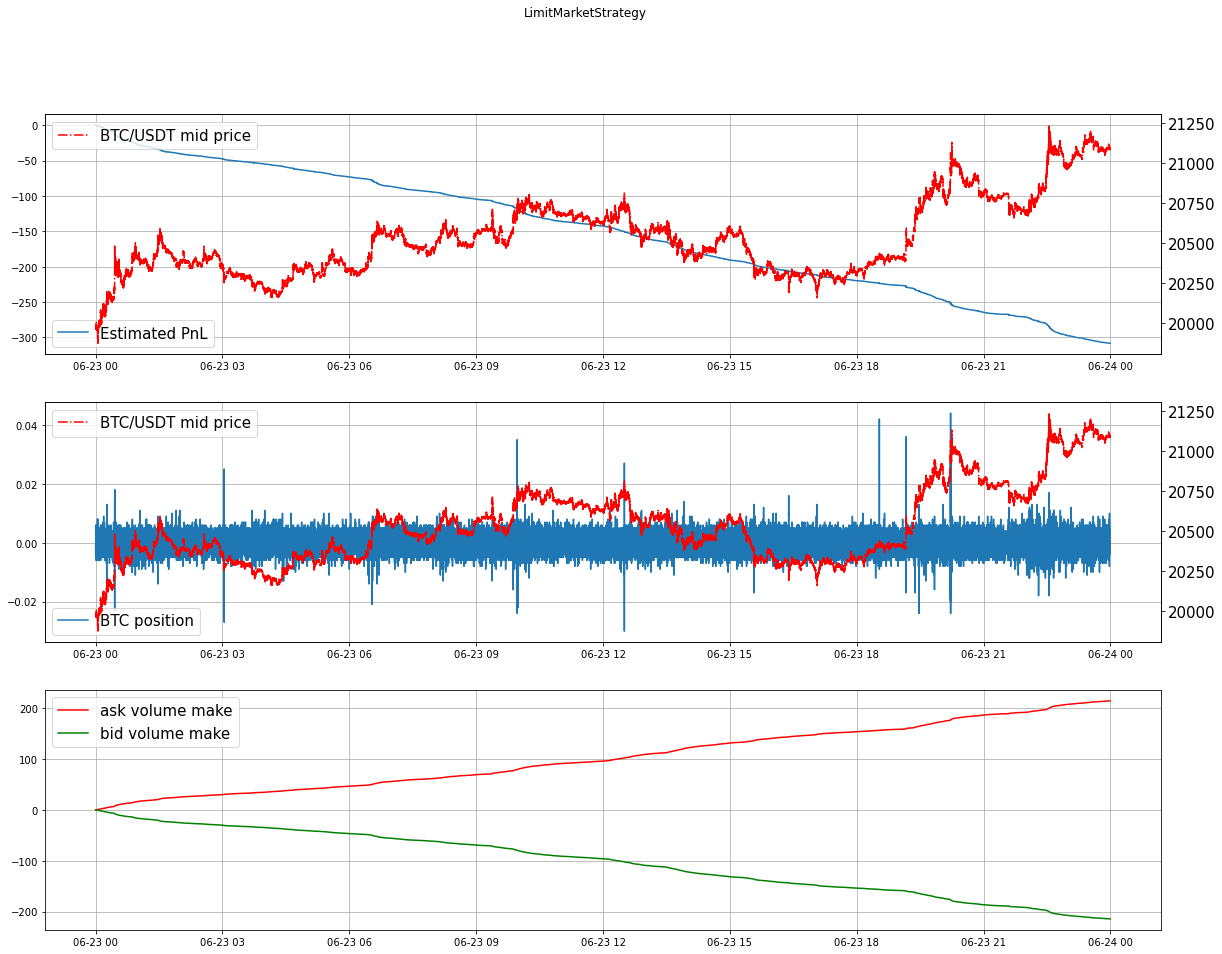

In [5]:
df_to_analyze = trades.groupby('receive_ts').last().reset_index()
dt = pd.to_datetime(df_to_analyze.receive_ts)
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(20,15)
fig.suptitle('LimitMarketStrategy')
font_size = 15
plt.rcParams.update({'font.size':font_size})

ax1.plot(dt, df_to_analyze.PnL, '-', label = 'Estimated PnL')
ax1.grid()
ax4 = ax1.twinx()
ax4.plot(dt, df_to_analyze.mid_price, 'r-.', label = 'BTC/USDT mid price')
ax1.legend(fontsize = 15, loc = 3)
ax4.legend(fontsize = 15, loc = 0)

ax2.plot(dt, df_to_analyze.coin_position, '-', label = 'BTC position')
ax5 = ax2.twinx()
ax5.plot(dt, df_to_analyze.mid_price, 'r-.', label = 'BTC/USDT mid price')
ax2.grid()
ax2.legend(fontsize = 15, loc = 3)
ax5.legend(fontsize = 15, loc = 0)

ax3.plot(dt, df_to_analyze.ask_volume, '-', color = 'r', label = 'ask volume make')
ax3.grid()
ax3.plot(dt, -1*df_to_analyze.bid_volume, '-', color = 'g', label = 'bid volume make')
ax3.legend()

plt.show()